In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Activation,Layer,Lambda
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

In [2]:
import warnings
warnings.filterwarnings("ignore")

___PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS___  

## __Data collection and description__ 

In [3]:
df = pd.read_csv("gas_turbines.csv")

In [4]:
df1 = df.copy()

In [5]:
pd.set_option("max_columns", None)

In [6]:
df1.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


In [7]:
df1.shape

(15039, 11)

In [8]:
df1.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [9]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,15039.0,17.764381,7.574323,0.522300,11.408000,18.1860,23.8625,34.9290
AP,15039.0,1013.199240,6.410760,985.850000,1008.900000,1012.8000,1016.9000,1034.2000
AH,15039.0,79.124174,13.793439,30.344000,69.750000,82.2660,90.0435,100.2000
AFDP,15039.0,4.200294,0.760197,2.087400,3.723900,4.1862,4.5509,7.6106
GTEP,15039.0,25.419061,4.173916,17.878000,23.294000,25.0820,27.1840,37.4020
TIT,15039.0,1083.798770,16.527806,1000.800000,1079.600000,1088.7000,1096.0000,1100.8000
TAT,15039.0,545.396183,7.866803,512.450000,542.170000,549.8900,550.0600,550.6100
TEY,15039.0,134.188464,15.829717,100.170000,127.985000,133.7800,140.8950,174.6100
CDP,15039.0,12.102353,1.103196,9.904400,11.622000,12.0250,12.5780,15.0810
CO,15039.0,1.972499,2.222206,0.000388,0.858055,1.3902,2.1604,44.1030


### Outlier Check

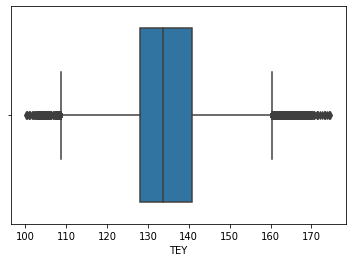

In [10]:
ax = sns.boxplot(df1['TEY'])

### There are few Outlier instances in our data

In [11]:
plt.rcParams["figure.figsize"] = 9,5

Skew: 0.14596270190452942
Kurtosis: -0.4870582497451621


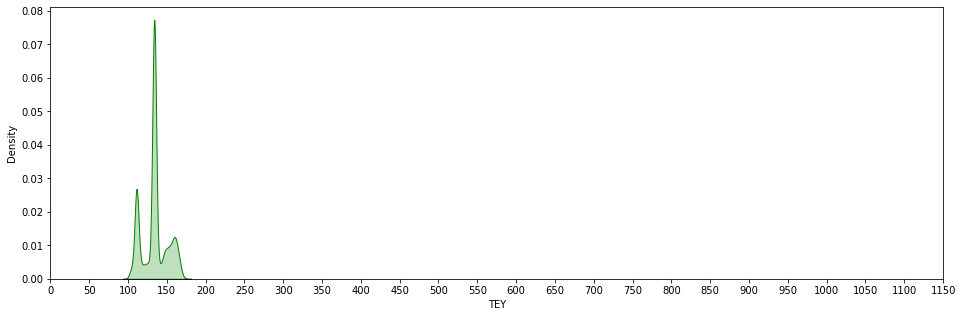

In [12]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df1['TEY'].skew()))
print("Kurtosis: {}".format(df1['TEY'].kurtosis()))
ax = sns.kdeplot(df1['TEY'],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

### The Data is highly skewed and has large kurtosis value  
### Majority of the  turbine energy yield(TEY) do not cover a large area

In [13]:
dfa = df1.drop('TEY', 1)
month_colum = dfa.select_dtypes(include='object').columns.tolist()

In [14]:
# plt.figure(figsize=(16,10))
# for i,col in enumerate(month_colum,1):
#     plt.subplot(2,2,i)
#     sns.countplot(data=dfa,y=col)
#     plt.subplot(2,2,i+2)
#     df1[col].value_counts(normalize=True).plot.bar()
#     plt.ylabel(col)
#     plt.xlabel('% distribution per category')
# plt.tight_layout()
# plt.show()  

### Majority of the range for data falls under 100-170

In [15]:
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

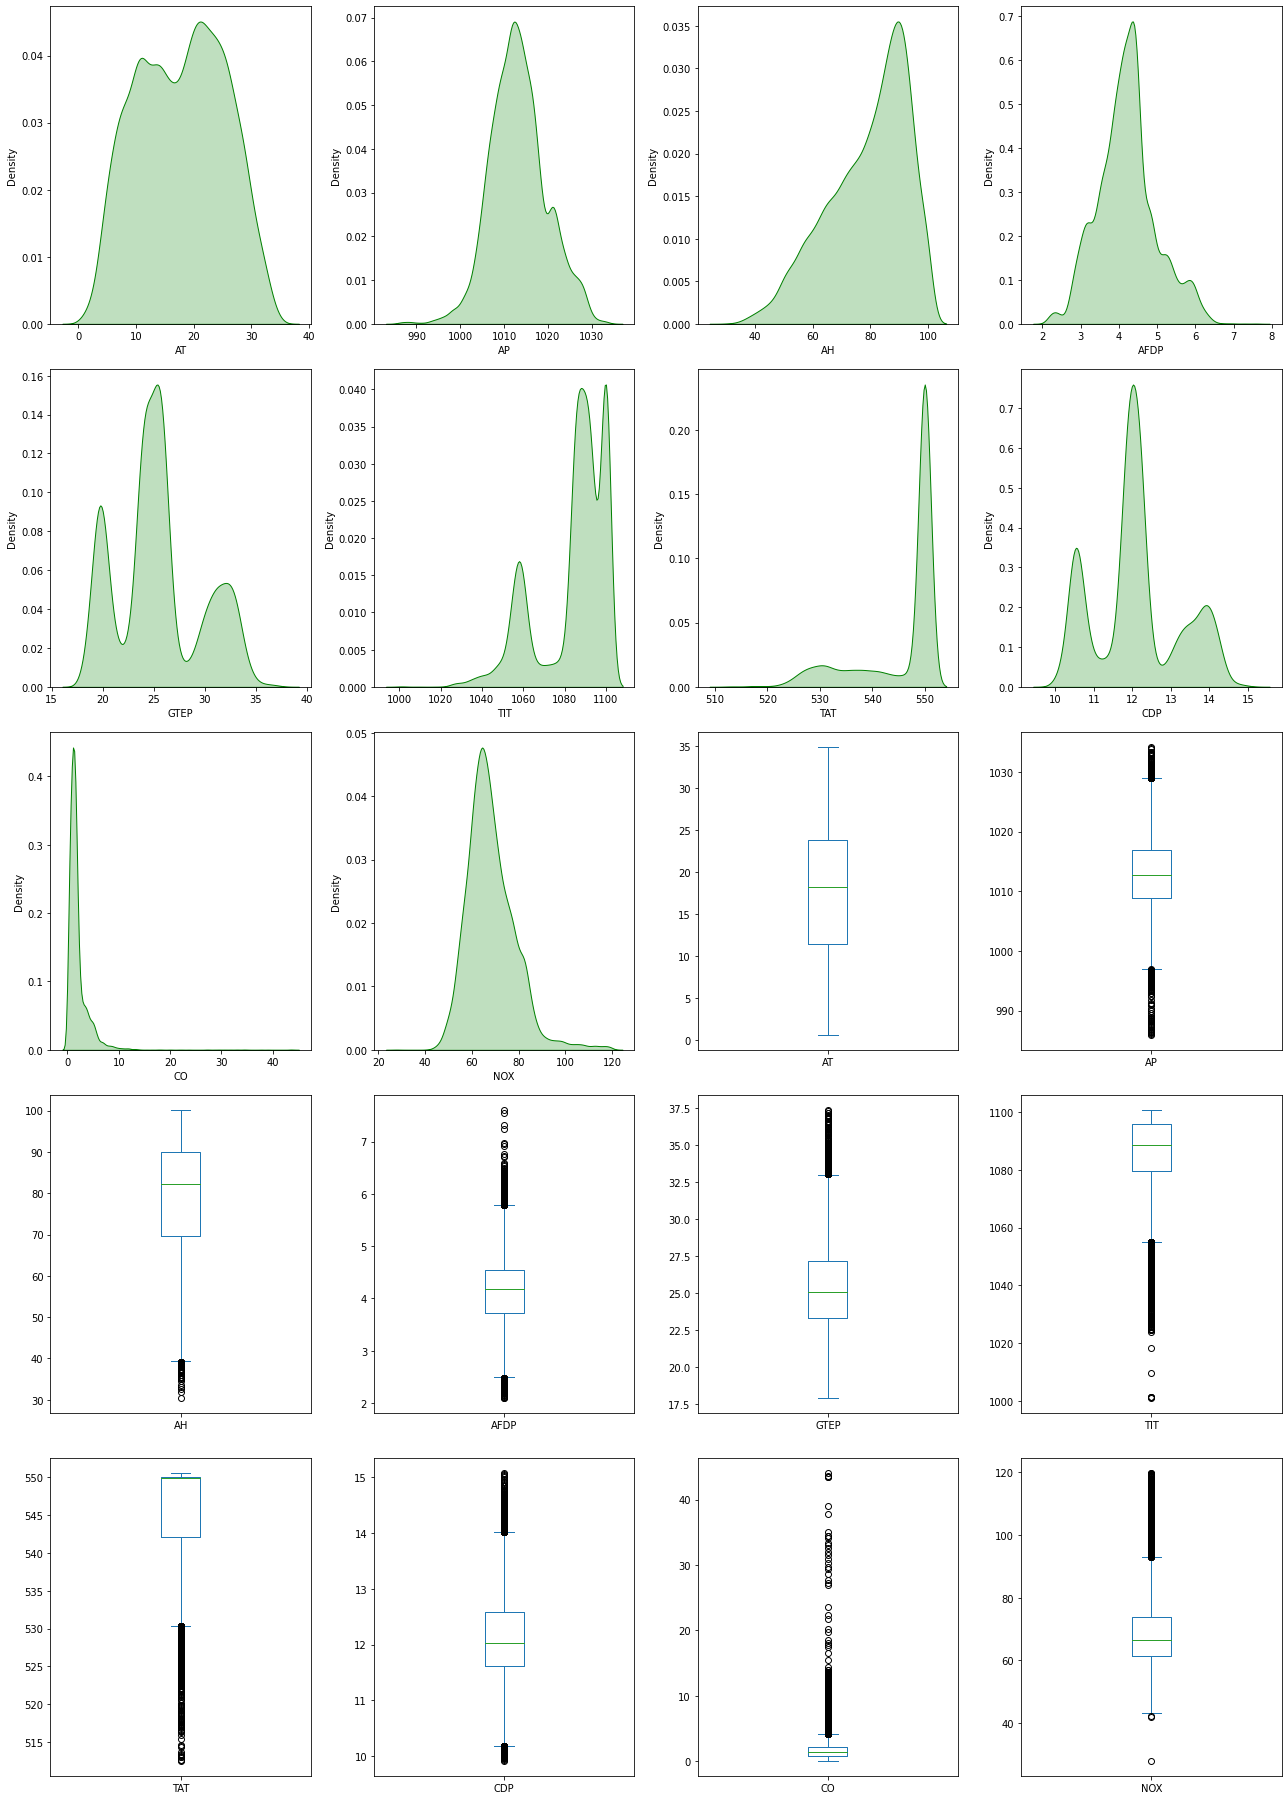

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
skewness,-0.030710,0.107601,-0.681224,0.315150,0.370987,-1.133744,-1.485524,0.263042,6.534577,1.126605
kurtosis,-0.987597,0.424070,-0.282476,0.281642,-0.618358,0.375232,0.847637,-0.589420,82.518116,2.660381


In [16]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

### Finding Correlation

In [17]:
corr = dfa.corr()

<AxesSubplot:>

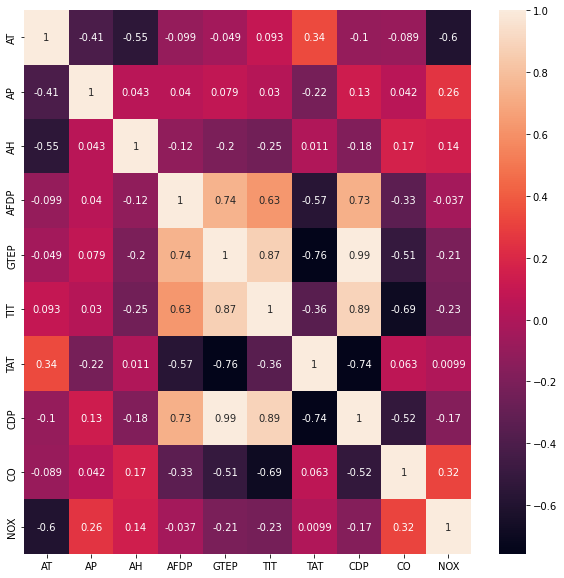

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)

## __Neural Network Model__ 

In [55]:
# df1.loc[df1["TEY"]<115,"TEY"]=0
# df1.loc[df1["TEY"]>115,"TEY"]=1

In [61]:
X = np.array(dfa)
y = np.array(df1.loc[:,"TEY"])

In [62]:
def norm_func(i):
    x = (i-i.min())/(i.max()-i.min())
    return (x)

In [63]:
X_norm = norm_func(X)

In [64]:
x_train,x_test,y_train,y_test= train_test_split(X_norm,y, test_size=0.2,random_state=2)

In [65]:
model = Sequential()
model.add(Dense(8, input_dim=10, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [66]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
model.fit(x_train, y_train, epochs=15, batch_size=10)

Epoch 1/15
1204/1204 [==============================] - 1s 607us/step - loss: 0.6182 - accuracy: 0.8044
Epoch 2/15
1204/1204 [==============================] - 1s 615us/step - loss: 0.5229 - accuracy: 0.8048
Epoch 3/15
1204/1204 [==============================] - 1s 606us/step - loss: 0.4930 - accuracy: 0.8048
Epoch 4/15
1204/1204 [==============================] - 1s 608us/step - loss: 0.4839 - accuracy: 0.8048
Epoch 5/15
1204/1204 [==============================] - 1s 604us/step - loss: 0.4814 - accuracy: 0.8048
Epoch 6/15
1204/1204 [==============================] - 1s 609us/step - loss: 0.4806 - accuracy: 0.8048
Epoch 7/15
1204/1204 [==============================] - 1s 629us/step - loss: 0.4803 - accuracy: 0.8048
Epoch 8/15
1204/1204 [==============================] - 1s 648us/step - loss: 0.4801 - accuracy: 0.8048
Epoch 9/15
1204/1204 [==============================] - 1s 616us/step - loss: 0.4801 - accuracy: 0.8048
Epoch 10/15
1204/1204 [==============================] - 1s 636u

In [68]:
_, accuracy = model.evaluate(x_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

376/376 [==============================] - 0s 500us/step - loss: 0.4799 - accuracy: 0.8048
Accuracy: 80.48


## __Conclusion__ 

In [69]:
predictions = model.predict(x_train)

In [72]:
for i in range(5):
    print('%s => %d (expected %d)\n' % (X[i].tolist(), predictions[i], y[i]))

[6.8594, 1007.9, 96.799, 3.5, 19.663, 1059.2, 550.0, 10.605, 3.1547, 82.722] => 0 (expected 0)

[6.785, 1008.4, 97.118, 3.4998, 19.728, 1059.3, 550.0, 10.598, 3.2363, 82.776] => 0 (expected 0)

[6.8977, 1008.8, 95.939, 3.4824, 19.779, 1059.4, 549.87, 10.601, 3.2012, 82.468] => 0 (expected 0)

[7.0569, 1009.2, 95.249, 3.4805, 19.792, 1059.6, 549.99, 10.606, 3.1923, 82.67] => 0 (expected 0)

[7.3978, 1009.7, 95.15, 3.4976, 19.765, 1059.7, 549.98, 10.612, 3.2484, 82.311] => 0 (expected 0)

